In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import re
import time

# Assignment 2

## Calculating and Analyzing Stop Delays

## What are we looking to accomplish?

Here we will again be loading in files available from STIB API as well as some files that were processed earlier during speed analysis.

 > #### The most significant challenge to calculate delays is determining whether a bus arriving at a stop is late or early.

Assumptions needed to be made to create a manageable data set for further predictions. An early approach was to match a buses actual arrival time at a stop to the nearest scheduled time, however this resulted in very symmetric delay data — a bus was considered early or late an equal number of times. New limits were put in place that reflect client expectations. A STIB client does not care WHICH bus they are getting on.

For example, if a bus is meant to arrive at 12:10, 12:20 and 12:30, it doesn't matter that a bus that was supposed to arrive at 12:20 actually arrives at 12:30. To manage these scenarios, there is a lower bound in place for how early a bus is allowed to be (current it is set to `200 secounds`). An upper bound is set at `1400 secounds` based on a visual heatmap analysis of the delay times to see choose a reasonable time outside of outliers.

To begin, we will import required libraries and define some helper functions before doing some additional transformation of the data to suit our needs.

## Utility Functions

Functions that we use all around our assignment. 


In [3]:
# get seconds from hh:mm:ss format
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [4]:
# get hh:mm:ss format from seconds
def get_hhmmss(seconds: int):
  return time.strftime('%H:%M:%S', time.gmtime(seconds))


In [5]:
# get hour from hh:mm:ss
def get_hour(hour_str: str):
  return int(hour_str.split(':')[0])

# Data input and processing




In this part of the assignment we are loading the static data and the vehicle snapshots to our notebook because we will need to calculate the delays for the vehicles that or on a stop.
We need to see the structure of the data, analyze it and decide how we are going to manipulate it in order to use it for our assignment.

We are using the gtfs files from September 3rd which we will reffere to as **static** files and the vehicle positions as **vehicle positoins or dynamic data**.

## Static GTFS Data


Loading the static data:

In [38]:
calendar = pd.read_csv('../data/raw/gtfs/calendar.txt')
calendar_dates = pd.read_csv('../data/raw/gtfs/calendar_dates.txt')
routes = pd.read_csv('../data/raw/gtfs/routes.txt')
stops = pd.read_csv('../data/raw/gtfs/stops.txt')
stop_times = pd.read_csv('../data/raw/gtfs/stop_times.txt')
trips = pd.read_csv('../data/raw/gtfs/trips.txt')

### Stops

We noticed that the stop_id's from stops.csv are not clean. Most of the stops were duplciated or had different records. Most of them were in a format with zeros up front and some letters at the end while still referencing to the same longtitude and latitude for that stop.

This is the part where we clean the stops and later use them as cleaned in the rest of the notebook.

In [39]:
stops.head(1)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,0089,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0


In [40]:
stops['stop_id'] = stops['stop_id'].map(lambda x: int(re.sub('[^0-9]', '', x))) # clean the letters and zeros
stops = stops.drop_duplicates() # remove the duplicates['stop_id'] = stops['stop_id'].map(lambda x: int(re.sub('[^0-9]', '', x))) # clean the letters and zeros

In [41]:
stops.head(1)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,89,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0


We are doing the same thing for stop_times as we also use a stops column.

In [42]:
stop_times['stop_id'] = stop_times['stop_id'].map(lambda x: int(re.sub('[^0-9]', '', str(x)))) # clean the letters and zeros
stop_times = stop_times.drop_duplicates() # remove the duplicates


### Calendar



We can reduce the day columns and create one column holding this information. 

We also noticed that we only have the following type of patterns in the calendar.csv file:

- 1111100
- 0000010
- 0000001

Therefore we can conclude that we can use the following notation:

We use the following values:
0 - weekday, 1, saturday, 2 sunday, 3 else

In [43]:
calendar.head(1)

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,234578052,1,1,1,1,1,0,0,20210823,20210831


In [44]:
# transform calendar_dates
calendar['day'] = calendar.apply(lambda x: 0 if x.monday==1 else 1 if x.saturday==1 else 2 if x.sunday==1 else 3 , axis=1)
calendar.drop(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'], axis=1, inplace=True)



In [45]:
calendar.head(1)

,service_id,start_date,end_date,day
0,234578052,20210823,20210831,0


## Join the static files

In order to ease our life we decided to deal with one big table where we store all the needed data from the static gtfs files.

We called this table trips_merged as we have information for every single STIB's trip from the gtfs data. From this part on we may refere to this table as **trips**.

We can see from which date is this trip running, which calendar does it follow, at what time is it supposed to stop, what is the name of the stop, the line and other usefull information which we can be used to find the delay.

In [ ]:
# make the big join, we have all the needed information
# del trips_merged
routes = routes[['route_id','route_short_name']]
stops = stops[['stop_id','stop_name']]
trips = trips[['route_id','service_id','trip_id','trip_headsign','direction_id']]
stop_times = stop_times[['trip_id','arrival_time','stop_id','stop_sequence']]
trips_merged = trips.merge(stop_times, on='trip_id', how='inner')\
                    .merge(calendar, on='service_id', how='inner')\
                    .merge(stops, on='stop_id', how='inner')\
                    .merge(routes, on='route_id', how='inner')


In [ ]:
trips_merged.head(1)

,route_id,service_id,trip_id,trip_headsign,direction_id,arrival_time,stop_id,stop_sequence,start_date,end_date,day,stop_name,route_short_name
0,24,235954071,112387248235954071,SIMONIS,1,21:07:00,4014,1,20210823,20210831,0,BEEKKANT,87


## Vehicle Positions

Loading the vehicle postions:

Notice: We have previosly merged all .json vehicle files into a .csv one called .vehiclePositions.csv

In [ ]:
vehicle_positions = pd.read_csv('../data/processed/assignment2/vehiclePositions.csv')

In [ ]:
vehicle_positions.head(1)

,Timestamp,LineId,DirectionId,DistanceFromPoint,PointId
0,1630914886924,1,8161,1,8012


Because our vehicle_positions have a timestamp, we have to get usefull information from that value. Therefore we are adding 3 new columns from the timestamp column.

timestamp -> date, hour, day

- The date is in YYYYMMDD format. 
- The hour is extracted in HH:MM:SS.
- The day is either 0 if it is woorking day, 1 if Saturday, 2 if Sunday. We are deriving these categories from the Timestamp 

It is important to notice that we are savinga new file called *vehiclePositionsTime.csv* which we can use later in our notebook. 

In [ ]:
# timestamp -> date, hour, day
# USE ONLY ONCE IF YOU NEED TO GENERATE THE COLUMNS FROM THE BASE FILE VEHICLEPOSITOISN

weekdays = ['Monday','Tuesday','Wednesday', 'Thursday','Friday']

vehicle_positions['date'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')
vehicle_positions['hour'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')
vehicle_positions['day'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')

vehicle_positions['date'] = vehicle_positions['date'].dt.strftime("%Y%m%d").astype(int)
vehicle_positions['hour'] = vehicle_positions['hour'].dt.strftime("%H:%M:%S")
vehicle_positions['day'] = vehicle_positions['day'].dt.strftime("%A") \
                    .apply(lambda x: 0 if x in weekdays else 1 if x=='Saturday' else 2 if x=='Sunday' else 3)

Because this operation is costly, we can't always run this code. Therefore once we run it we save it and we can use the vehiclePositionsTime.csv file.

In [ ]:
vp = vehicle_positions.copy()

In [ ]:
vehicle_positions.to_csv('../data/processed/assignment2/vehiclePositionsTime.csv',mode='w', index=False)

In [ ]:
vehicle_positions.head(1)

,Timestamp,LineId,DirectionId,DistanceFromPoint,PointId,date,hour,day
0,1630914886924,1,8161,1,8012,20210906,07:54:46,0


# Caluclating the delays

In [ ]:
vehicle_positions = pd.read_csv('../data/processed/assignment2/vehiclePositionsTime.csv')

Our goal now is to caluclate the delays for the vehicles from the vehicle positions file that are on a certain stop.

The way we will do this is that we will pick the vehicles that are on the stop. As we don't have the vehicle ID in the static files we will have to make an **assumption** which tripid matches the vehicle the most. 

In [ ]:
# for a chosen line number get the coresponding subtable from the trips and vehicle positions
def getLineAndVehicle(line_number: int):
    line = trips_merged[trips_merged['route_short_name'] == str(line_number)]
    vehicle = vehicle_positions[vehicle_positions['LineId'] == line_number]
    return line, vehicle

In [ ]:
# get the stop name from a given stop number
def getStopName(stop_number: str):
    for k,v in stops_dictionary.items():
        if(stop_number in v):
            return k

Using this function we are removing the vehicle positions that are between the first arrival time in the trips and last expected time or midnight for that exact vehicle. 

We are doing this because there are a lot of vehicles who are running outside of their schedule. Meaning that we have timestamps which are at 2 AM, but there are no scheduled busses between 11PM and 5AM.

We are also avoiding all the busses after midnight because they are represented as 00:00:00 in the vehicle positions file, while in the static files 1AM is represented as 25:00:00. We are not able to compare them as when we conver them to seconds, 01:00:00 AM will give much smaller value than 25:00:00 and will match with the earliest scheduled stop, therefore the delay will be huge and without meaning. We are also not converting the hours after 24:00:00 to 00:00:00 because...? i forgot why

In [ ]:
def filterVehicles(line,vehicles):
  first_vehicle = line.arrival_time.min()
  last_vehicle = line.arrival_time.max() # could be > '24:00:00'

  # dropping by earliest vehicles (also removes the after midnight busses)
  # we give a window of 1 minute if it leaves earlier 
  vehicles.drop(vehicles.loc[(vehicles['hour'].values <= get_hhmmss(get_sec(first_vehicle) - 60))].index, inplace=True)

  # dropping busses after the last vehicle
  # It is optional because if it's past midnight it is dropped by the previous drop
  if(last_vehicle < '24:00:00'):
    vehicles.drop(vehicles.loc[(vehicles['hour'].values >= last_vehicle)].index, inplace=True)
  
  # drop the rows that are not on the bus stop
  vehicles.drop(vehicles.loc[(vehicles['DistanceFromPoint'].values != 0)].index, inplace=True)

Here we get the line corresponding to the vehicle and we filter all the possible trips that might be on that stop, between the dates in which our bus is riding and the date as well. 

This function will return the list of the possible trips to match 

In [ ]:
# get the possible trips that match our vehicle snapshot
def matchTimeWithStops(line, vehicle_timestamp):
    return line.loc[(line['stop_id'].values == vehicle_timestamp.PointId) & \
                (line['start_date'].values <= vehicle_timestamp.date) & \
                (line['end_date'].values >= vehicle_timestamp.date) & \
                (line['day'].values == vehicle_timestamp.day)]


Once we get the possible trips from `matchTimeWithStops`, we are trying to find the one that is closest to our vehicle's snapshot.

The method is very naive as we are finding the closest delay to zero. We are first getting the difference between the vehicle snapshot and the delays and then we are finding the argmin in the array of delays.
Once we have the two closest values to zero we first check if inside the [min_bound, 0] interval. If it is, then we prioritize the negative delays, when the vehicles are early. Otherwise we prioritize when they are late [0, max_bound]
This logic is being done in the ```getBestDelay``` function

In [ ]:
def getBestDelay(val1, val2, min_bound, max_bound):
    # [min_bound,0] priority, then [0, max_bound]
    # check if it is between min and 0
    if(min_bound <= val1 <= 0):
        if(min_bound <= val2 <= 0):
            return max(val1,val2)
        else:
            return val1
    elif(min_bound <= val2 <=0):
        return val2

    # check if it is between 0 and min
    if(0 <= val1 <= max_bound):
        if(0 <= val2 <= max_bound):
            return min(val1,val2)
        else:
            return val1
    elif(0 <= val2 <= max_bound):
        return val2

    return None

We are also using numpy vectorization as it is the fastest way to itterate through dataframes.

In [ ]:
def calculateTheDelay(delays, vehicle_row, interval):
    def f(x, vehicle_row):
      return get_sec(vehicle_row) - get_sec(x)
      
    fvec = np.vectorize(f) 
    result_array = fvec(delays.arrival_time, vehicle_row.hour)
    result_array_abs = np.abs(result_array)
    argsort = np.argsort(result_array_abs)

    # there are cases when we only have < 2 values which are very rare. 
    try:
        arg1, arg2 = np.argsort(result_array_abs)[:2]
    except ValueError:
        return None

    min_bound = interval[0]
    max_bound = interval[1]

    val1 = result_array[arg1]
    val2 = result_array[arg2]
    best_delay = getBestDelay(val1, val2, min_bound, max_bound)


    # print(f"{np.unique(delays.stop_id)} - {np.unique(delays.stop_name)} - {val1},{val2} -> {best_delay}")
    return best_delay

In the following function we are iterating through every line and vechicle snapshots and we calculate the delay for the vehicles that are on the stop. We are using the three key functions that we mentioned before this one which are the essential logic when we are searching for the delay.

At the end we are creating a new column called 'Delay' in the vehicle position subtable for that line where we add the delay that we have counted. For the snapshots that are not on the stop we give them Null value. 

We are also specifying the ```INTERVAL``` which is the tolerance treshold for a vehicle being early or late

In [ ]:
line_numbers = vehicle_positions.LineId.unique() # get all the lines that are on the network
INTERVAL = [-200, 1400]

for number in line_numbers:
    line, vehicles = getLineAndVehicle(number) # ex for line 1, we get the static files of line 1 and vp of line 1
    filterVehicles(line,vehicles)
    print(f"LINE{number}")
    total_delays = []
    
    for index, vehicle_row in vehicles.iterrows(): # go through each bus that is on the stop TBD: iterrows is slow
        delays = matchTimeWithStops(line, vehicle_row) # get the delays from the matched possible stoptimes for that vehicle in that line

        if delays.empty != True: # avoid when it doesn't find anything
            final_delay = calculateTheDelay(delays, vehicle_row, INTERVAL)
            total_delays.append(final_delay)
        else:
            total_delays.append(None) # it is possible that we don't find anything from calculateTheDelay (ex. missing stops)

    vehicles['delay'] = total_delays
    vehicles.to_csv(f'../data/processed/assignment2/vehicleDelaysLine{number}.csv',mode='w', index=False)


Because we are setting the interval manually, we would like to see the average difference between every bus that comes to the stop for every line.

This is something that we might work in the future as we would like to have th

In [ ]:
line, _ = getLineAndVehicle(71)

ld = line[line['direction_id'] == 0]

avg_diff1 = {}

for number in vehicle_positions.LineId.unique():

    line, _ = getLineAndVehicle(number)
    rush_hour = line[(line['arrival_time'] > '15:00:00') & (line['arrival_time'] < '16:00:00')]
    service_id = rush_hour.iloc[-1,1]
    stop_id = rush_hour.iloc[-1,6]

    line.arrival_time = line.arrival_time.apply(lambda x: get_sec(x))

    avg_diff1[number] = np.mean(np.diff(np.unique(line[(line['stop_id'] == stop_id) & (line['service_id'] == service_id)].arrival_time)))




In [ ]:
avg_diff1

In [ ]:
avg_diff

{1: 424.6125,
 2: 458.40277777777777,
 3: 484.61538461538464,
 4: 481.2676056338028,
 5: 412.5297619047619,
 6: 439.9415584415584,
 7: 590.4201680672269,
 8: 605.1282051282051,
 9: 640.3636363636364,
 12: 439.6363636363636,
 13: 886.578947368421,
 14: 779.3406593406594,
 17: 894.6153846153846,
 19: 549.4488188976378,
 20: 719.3548387096774,
 21: 860.0,
 25: 603.5897435897435,
 27: 1464.878048780488,
 28: 447.4172185430464,
 29: 888.0,
 33: 1202.5,
 34: 1568.5714285714287,
 36: 435.97402597402595,
 37: 1070.0,
 38: 676.5833333333334,
 39: 697.7319587628866,
 41: 905.5211267605633,
 42: 888.3333333333334,
 43: 1064.27868852459,
 44: 718.125,
 45: 740.4545454545455,
 46: 1444.0,
 47: 286.80497925311204,
 48: 468.6510067114094,
 49: 8115.0,
 50: 1310.9433962264152,
 51: 592.1311475409836,
 53: 739.7802197802198,
 54: 789.3975903614457,
 55: 966.6666666666666,
 56: 880.0,
 57: 917.8947368421053,
 58: 2585.4545454545455,
 59: 748.6666666666666,
 60: 850.9090909090909,
 61: 862.1917808219179,

**All the subtables are saved as a new file vehicleDelaysLine{number}.csv, these files are then merged in vehicleDelays.csv**

# Cleaning the delays


In this section we will use the calculated delays and remove the null values and do some data exploration with our delays

vehicleDelays.csv is generated by a shell comand from the vehcileDelaysLine{number}.csv files



```
head -1 vehicleDelaysLine1.csv > vehicleDelays.csv   
tail -n -q +2  vehicleDelaysLine* >> vehicleDelays.csv
```



In [22]:
# We are loading the vehicle delays here from a new file or we can use the same
delays_uncleaned = pd.read_csv('../data/processed/assignment2/vehicleDelays.csv')
# removing the None values from delay.
delays = delays_uncleaned.dropna(subset=['delay'])

In [23]:
delays = delays.drop_duplicates() # we could have multiple snapshots at the same time for the same vehicle

As there have been null values when calculating the delays in vehicle positions, mostly due to not having the static gtfs timetables for some dates, we are dropping almost 25% of the data.

In [24]:
print(f"Delays before cleaning:\t{len(delays_uncleaned.index) }")
print(f"Delays after dropping the null values:\t{len(delays.index)}")
print(f"Percentage of null values dropped:\t{(1 - (len(delays.index) / len(delays_uncleaned.index))) * 100 }")

Delays before cleaning:	6416423
Delays after dropping the null values:	4274610
Percentage of null values dropped:	33.38017147560252


We also see that by line we get peaks of dropped data for lines like 37, 69, 70, 95. One of the reasons is because some stops in the vehicle position files do not exist in the gtfs file. An example for that would be the terminus Grand-Place which ID is not in the gtfs files.

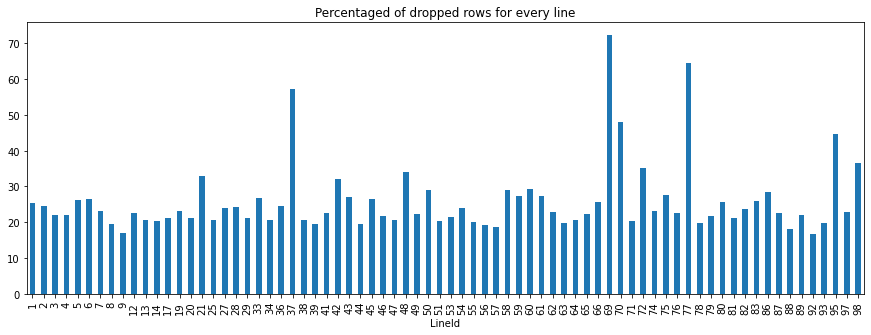

In [25]:

dropped_rows_by_line = delays_uncleaned.groupby(['LineId'])['delay'].agg(lambda x: x.isnull().sum() / len(x) *100)

dropped_rows_by_line.plot(kind='bar', figsize=(15,5), title="Percentaged of dropped rows for every line")

We should now check the outliers and see how our data is being distributed


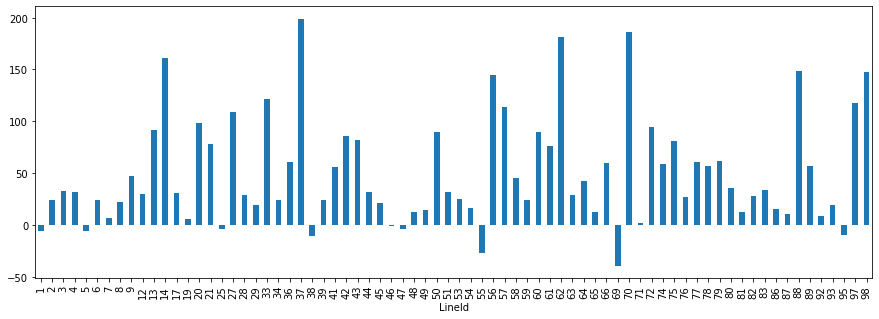

In [26]:
delays.groupby('LineId')['delay'].median().plot(kind='bar', figsize=(15,5))

We see that the median values are mostly positive, which means that the for each line we have more delays. 

Now let's see the mean for our lines

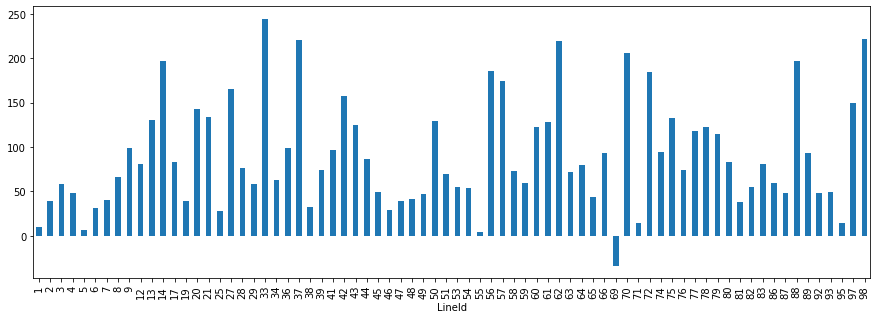

In [27]:
delays.groupby('LineId')['delay'].mean().plot(kind='bar', figsize=(15,5))

From both mean and median we see that the line number 69 has negative values which means that it is early.

We can also notice how metros and trams are having delays at around 50 seconds because they are going either underground where there is no other trafic or they have their own signalization when they are on the ground.

In [28]:
delays.to_csv('../data/processed/assignment2/delaysCleaned.csv', index=False)

# Export data

We are preparing the data for the visualization part

In [29]:
delays = pd.read_csv('../data/processed/assignment2/delaysCleaned.csv')
delays = delays.dropna()

In [30]:
delays = delays.drop(columns=['DistanceFromPoint'], axis=1)
delays.columns = ['Timestamp', 'LineId', 'TerminusStop', 'CurrentStop', 'Date','Hour','Day','Delay']
delays['Delay'] = delays['Delay'].astype(int)
delays['ExpectedArrivalTime'] = [ get_hhmmss(get_sec(x) - y) for x, y in zip(delays['Hour'], delays['Delay'])]
delays = delays.drop_duplicates()


In [31]:
delays.head()

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
0,1630914886924,12,9600,9600,20210906,07:54:46,0,286,07:50:00
1,1630914886924,12,1780,9600,20210906,07:54:46,0,286,07:50:00
2,1630914886924,12,9600,1780,20210906,07:54:46,0,-14,07:55:00
3,1630914886924,12,1780,2250,20210906,07:54:46,0,-74,07:56:00
4,1630914917746,12,9600,9600,20210906,07:55:17,0,317,07:50:00


While visualizing the data in rapidminer we noticed that the vehicles spend a lot of time on the stops. For one stop, we can have 5-6 snapshots of that vehicle staying on the stop. 
We noticed a lot of vehicle snapshots on the first stop of the trip. We **assume** that the drivers have started the device to run before even leaving the stop.

We are demonstrating this case by looking at the time a bus stays on a certain stop

In [32]:
delays_line5 = delays[delays['LineId'] == 5]

We can see the snapshots on which the vehicle is on an intermediate stop.

In [34]:
start_stops = np.unique(delays_line5['TerminusStop'].values)
intermediate_delays = delays.loc[(delays['LineId'] == 5) & ~(delays['CurrentStop'].isin(start_stops))]
intermediate_delays.groupby(['LineId','Date','Day','TerminusStop','CurrentStop', 'ExpectedArrivalTime'])['Delay'].agg(list)

LineId  Date      Day  TerminusStop  CurrentStop  ExpectedArrivalTime
5       20210906  0    8161          8652         19:20:34                               [-10, 22]
                                     8662         19:21:56                                [-28, 5]
                                     8672         19:23:19                               [-15, 17]
                                     8692         19:25:47                                    [-4]
                                     8702         19:27:12                                     [3]
                                                                                   ...            
        20210918  1    8731          8261         19:32:28               [165, 198, 230, 262, 294]
                       8733          8271         09:19:59                              [137, 168]
                                     8281         09:21:22                                   [181]
                                     82

Now, we decide are only getting the first snapshot when that vehicle arrives on an intermediate stop and we discard the other one's on that stop for that vehicle.

In [35]:
intermediate_delays = intermediate_delays.drop_duplicates(subset=['LineId','Date','Day','TerminusStop','CurrentStop', 'ExpectedArrivalTime'], keep='first')
intermediate_delays.groupby(['LineId','Date','Day','TerminusStop','CurrentStop', 'ExpectedArrivalTime'])['Delay'].agg(list)

LineId  Date      Day  TerminusStop  CurrentStop  ExpectedArrivalTime
5       20210906  0    8161          8652         19:20:34               [-10]
                                     8662         19:21:56               [-28]
                                     8672         19:23:19               [-15]
                                     8692         19:25:47                [-4]
                                     8702         19:27:12                 [3]
                                                                         ...  
        20210918  1    8731          8261         19:32:28               [165]
                       8733          8271         09:19:59               [137]
                                     8281         09:21:22               [181]
                                     8291         09:22:36               [139]
                                     8741         09:24:10               [139]
Name: Delay, Length: 79358, dtype: object


In order to avoid these problems we are dropping some rows:
- We only take the last snapshot when our vehicle is on the first stop.
- We take the first stop when the vehicle reaches an intermediate stop and on the last/terminus stop.

In the following code we are treating all the cases

In [ ]:
line_numbers = delays.LineId.unique()
drop_condition = ['LineId','Date','Day','TerminusStop','CurrentStop','ExpectedArrivalTime']

all_delays = []

for line in line_numbers:
  # dropping the start stops
  start_stops = np.unique(delays[delays['LineId'] == line]['TerminusStop'].values)

  start_delays = delays.loc[(delays["LineId"] == line) & \
                            (delays['TerminusStop'] != delays['CurrentStop']) &  # it is not the terminus stop
                            (delays['CurrentStop'].isin(start_stops))] # the current stop is a start or terminus stop
  start_delays = start_delays.drop_duplicates(subset=drop_condition, keep='last')

  # dropping the intermediate stops
  intermediate_delays = delays.loc[(delays['LineId'] == line) & \
                              ~(delays['CurrentStop'].isin(start_stops))]

  intermediate_delays = intermediate_delays.drop_duplicates(subset=drop_condition, keep='first')

  # dropping the terminus stops
  terminus_delays = delays.loc[(delays['LineId'] == line) & \
                               (delays['TerminusStop'] == delays['CurrentStop'])]

  terminus_delays = terminus_delays.drop_duplicates(subset=drop_condition, keep='first')

  # merging them all in one
  df_concat = pd.concat([start_delays.reset_index(drop=True),\
                         intermediate_delays.reset_index(drop=True),\
                         terminus_delays.reset_index(drop=True)])
  
  all_delays.append(df_concat.reset_index(drop=True))

# for each line we merge the delays
final_filtered_delays = pd.concat(all_delays)

In [ ]:
final_filtered_delays

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
0,1630914886924,12,9600,1780,20210906,07:54:46,0,-14,07:55:00
1,1630914886924,12,1780,2250,20210906,07:54:46,0,-74,07:56:00
2,1630915011138,12,1780,9600,20210906,07:56:51,0,411,07:50:00
3,1630915074628,12,9600,1780,20210906,07:57:54,0,-6,07:58:00
4,1630915202427,12,1780,9600,20210906,08:00:02,0,-58,08:01:00
...,...,...,...,...,...,...,...,...,...
11656,1632002984861,9,1687,1687,20210918,22:09:44,1,44,22:09:00
11657,1632004253330,9,473,473,20210918,22:30:53,1,-127,22:33:00
11658,1632004724486,9,1687,1687,20210918,22:38:44,1,-16,22:39:00
11659,1632005097438,9,473,473,20210918,22:44:57,1,-123,22:47:00


In [ ]:
final_filtered_delays.to_csv('../data/processed/assignment2/final_filtered_delays.csv', index=False)

These are the final delays of this assignment. We will also use them in the visualization part.

In [ ]:
final_filtered_delays.head()

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
0,1630914886924,12,9600,1780,20210906,07:54:46,0,-14,07:55:00
1,1630914886924,12,1780,2250,20210906,07:54:46,0,-74,07:56:00
2,1630915011138,12,1780,9600,20210906,07:56:51,0,411,07:50:00
3,1630915074628,12,9600,1780,20210906,07:57:54,0,-6,07:58:00
4,1630915202427,12,1780,9600,20210906,08:00:02,0,-58,08:01:00


# Statistics

In this part we will generate some statistics form the data.
We also picked line 5 in order to show some statistics regarding one line from the STIB network.

In [36]:
final_delays = pd.read_csv('../data/processed/assignment2/final_filtered_delays.csv')

In [46]:
final_delays = final_delays.merge(stops[['stop_name', 'stop_id']], left_on='CurrentStop', right_on='stop_id')
final_delays = final_delays.drop(columns=['stop_id'])

In [47]:
final_delays.head()

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime,stop_name
0,1630914886924,12,9600,1780,20210906,07:54:46,0,-14,07:55:00,TRONE
1,1630915074628,12,9600,1780,20210906,07:57:54,0,-6,07:58:00,TRONE
2,1630915268784,12,9600,1780,20210906,08:01:08,0,8,08:01:00,TRONE
3,1630915876546,12,9600,1780,20210906,08:11:16,0,376,08:05:00,TRONE
4,1630916005472,12,9600,1780,20210906,08:13:25,0,-95,08:15:00,TRONE


In [48]:
# creating the hour_interval column to know in which hour is the delay
final_delays['hour_interval'] = final_delays['Hour'].apply(lambda x: str(x.split(':')[0] + ':00'))

In [49]:
line5 = final_delays[final_delays['LineId'] == 5]

In [51]:
line5.head()

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime,stop_name,hour_interval
146969,1630915011138,5,8642,8071,20210906,07:56:51,0,-102,07:58:33,MERODE,07:00
146970,1630915334425,5,8642,8071,20210906,08:02:14,0,-89,08:03:43,MERODE,08:00
146971,1630915653306,5,8641,8071,20210906,08:07:33,0,-80,08:08:53,MERODE,08:00
146972,1630915971167,5,8642,8071,20210906,08:12:51,0,-72,08:14:03,MERODE,08:00
146973,1630916356000,5,8641,8071,20210906,08:19:16,0,3,08:19:13,MERODE,08:00


Text(0.5, 0.98, 'Line 5 mean delays per hour')

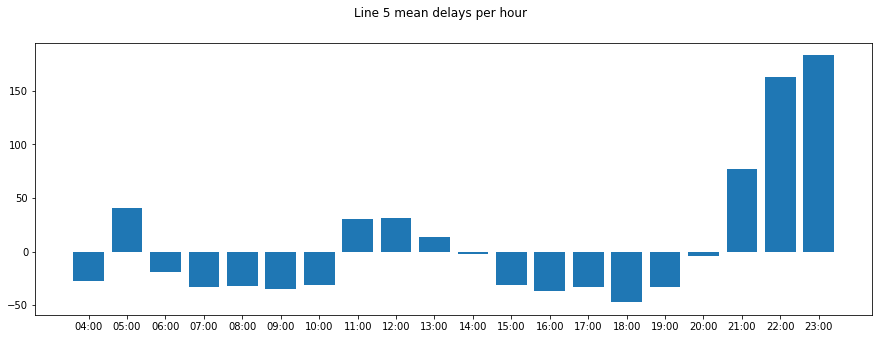

In [ ]:
# What point of the day do we have the biggest delays for line 5?

line5_delay = line5.groupby('hour_interval', as_index=False)['Delay'].mean()
line5_delay['hour_interval'].values
line5_delay['Delay'].values

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(line5_delay['hour_interval'].values,line5_delay['Delay'].values)
fig.suptitle('Line 5 mean delays per hour')


In [ ]:
# stops that have the biggest delay on line 5
delay_by_stop = line5.groupby('stop_name')['Delay'].mean()
delay_by_stop = delay_by_stop.sort_values()
delay_by_stop.tail()

stop_name
SAINTE-CATHERINE    -4.354205
SCHUMAN              1.979281
BIZET                4.085119
DELTA                8.794253
ERASME              67.821355
Name: Delay, dtype: float64

In [ ]:
# stop that are very early on line 5
delay_by_stop.head()

stop_name
PETILLON   -24.316170
VEEWEYDE   -24.226810
THIEFFRY   -23.251196
DEMEY      -22.033838
CERIA      -21.859994
Name: Delay, dtype: float64

In [ ]:
# stops that are the closest to be on time on line 5
delay_by_stop[delay_by_stop.abs().sort_values().head(10).index]

stop_name
SCHUMAN              1.979281
BIZET                4.085119
SAINTE-CATHERINE    -4.354205
JACQUES BREL        -7.488394
BEEKKANT            -7.512859
COMTE DE FLANDRE    -7.803862
DELTA                8.794253
PARC                -8.818603
GARE CENTRALE       -9.607653
HERRMANN-DEBROUX   -10.549991
Name: Delay, dtype: float64

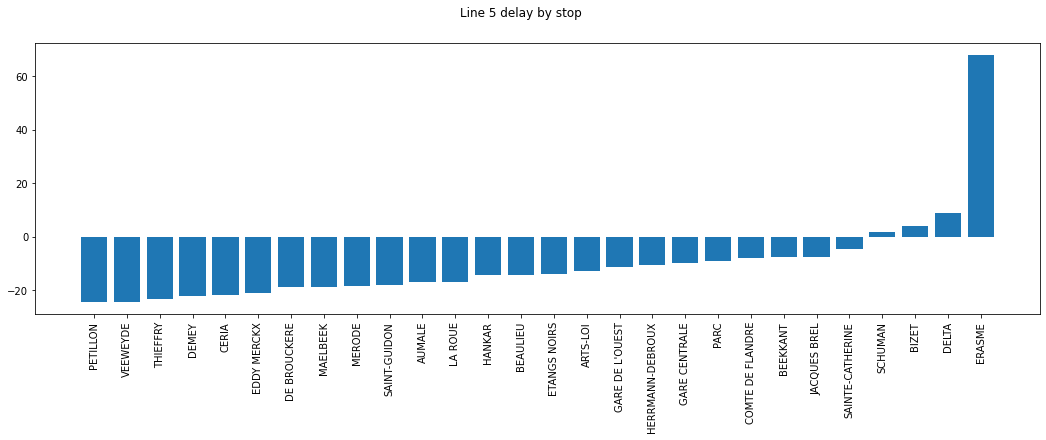

In [ ]:
line5_stop_delay = pd.DataFrame(delay_by_stop).reset_index()

fig, ax = plt.subplots(figsize=(18, 5))
plt.bar(line5_stop_delay['stop_name'].values,line5_stop_delay['Delay'].values)
fig.suptitle('Line 5 delay by stop')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# line that has the biggest delay
delay_by_line = final_delays.groupby('LineId')['Delay'].mean()
delay_by_line = delay_by_line.sort_values()
delay_by_line.tail()

LineId
55     8.430649
2     14.928415
7     20.766036
87    50.857861
38    60.944335
Name: Delay, dtype: float64

In [ ]:
# line that is early
delay_by_line.head()

LineId
5    -10.071684
55     8.430649
2     14.928415
7     20.766036
87    50.857861
Name: Delay, dtype: float64

In [ ]:
# line that is most on time
delay_by_line[delay_by_line.abs().sort_values().head(5).index]

LineId
55     8.430649
5    -10.071684
2     14.928415
7     20.766036
87    50.857861
Name: Delay, dtype: float64

In [ ]:
# average delay per stop on line5
line5.groupby(['CurrentStop', 'stop_name'])['Delay'].mean()

CurrentStop  stop_name       
8011         DE BROUCKERE         -31.279582
8012         DE BROUCKERE          -4.520025
8021         GARE CENTRALE         -8.368298
8022         GARE CENTRALE        -10.956246
8031         PARC                  -9.613838
8032         PARC                  -7.948220
8041         ARTS-LOI             -14.071846
8042         ARTS-LOI             -11.083925
8051         MAELBEEK             -12.621399
8052         MAELBEEK             -24.824190
8061         SCHUMAN               13.246686
8062         SCHUMAN              -10.657401
8071         MERODE               -21.985673
8072         MERODE               -14.106796
8201         THIEFFRY             -33.692564
8202         THIEFFRY             -11.049287
8211         PETILLON             -17.025852
8212         PETILLON             -31.980235
8221         HANKAR               -12.743097
8222         HANKAR               -16.095641
8231         DELTA                  3.451786
8232         DELTA       

In [ ]:
# Get which line is slow at what point of the day
final_delays.groupby(['LineId', 'hour_interval'])['Delay'].median()

LineId  hour_interval
2       05:00             66.0
        06:00             -1.0
        07:00             30.0
        08:00              6.0
        09:00            -12.0
                         ...  
87      18:00            -24.0
        19:00             46.0
        20:00            217.0
        21:00            177.0
        22:00             78.5
Name: Delay, Length: 116, dtype: float64

Text(0.5, 0.98, 'Schuman line 5 - mean delay per hour')

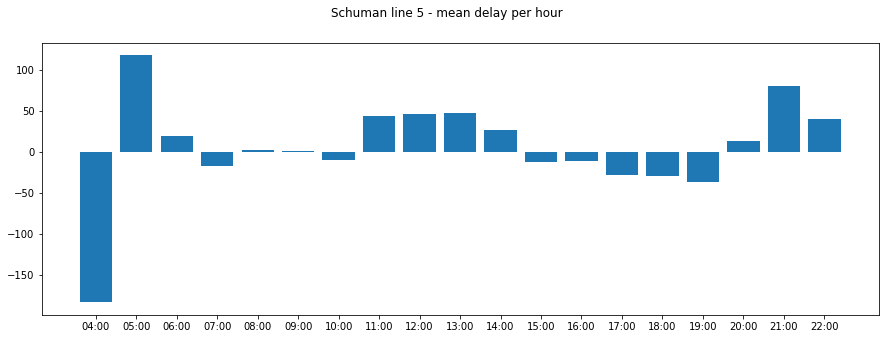

In [ ]:
# Get the delays for Schuman stop at different time of day on line 5

stop_by_hour = line5.groupby(['stop_name', 'CurrentStop', 'hour_interval'], as_index=False)['Delay'].mean()

schuman_stop = stop_by_hour[stop_by_hour['CurrentStop'] == 8061]
x,y = schuman_stop['hour_interval'].values, schuman_stop['Delay'].values
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x,y)
fig.suptitle('Schuman line 5 - mean delay per hour')


In [ ]:
# Foreach interval get the stop that is the busiest on the line
final_delays.groupby(['hour_interval','stop_name'])['Delay'].mean()

hour_interval  stop_name     
04:00          ARAUCARIA         -75.250000
               ARSENAL           118.800000
               BASCULE           184.285714
               BOILEAU            54.800000
               BORDET STATION    310.333333
                                    ...    
23:00          THIEFFRY          265.133333
               THOMAS             84.000000
               VAN PRAET         412.000000
               VERBOEKHOVEN       41.600000
               VUB               133.416667
Name: Delay, Length: 2597, dtype: float64